# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import time

%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)


cv2.destroyAllWindows()

# Compute the camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

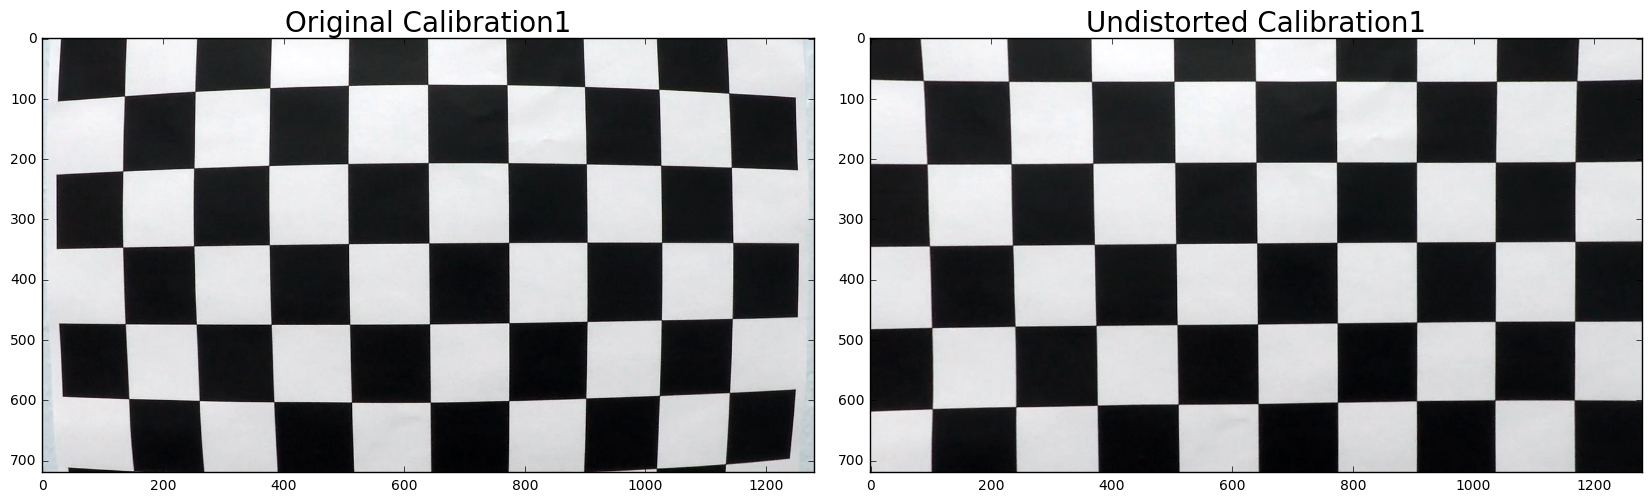

In [2]:
%matplotlib inline
# Read the sample image by cv2
sample_img = cv2.imread('camera_cal/calibration1.jpg')
# Undistort the image with cv2.undistort()
sample_undist = cv2.undistort(sample_img, mtx, dist, None, mtx)
# Show  and compare the original and undistorted figures with plt.subplots()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Original Calibration1', fontsize=20)
ax2.imshow(sample_undist)
ax2.set_title('Undistorted Calibration1', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a distortion correction to raw images

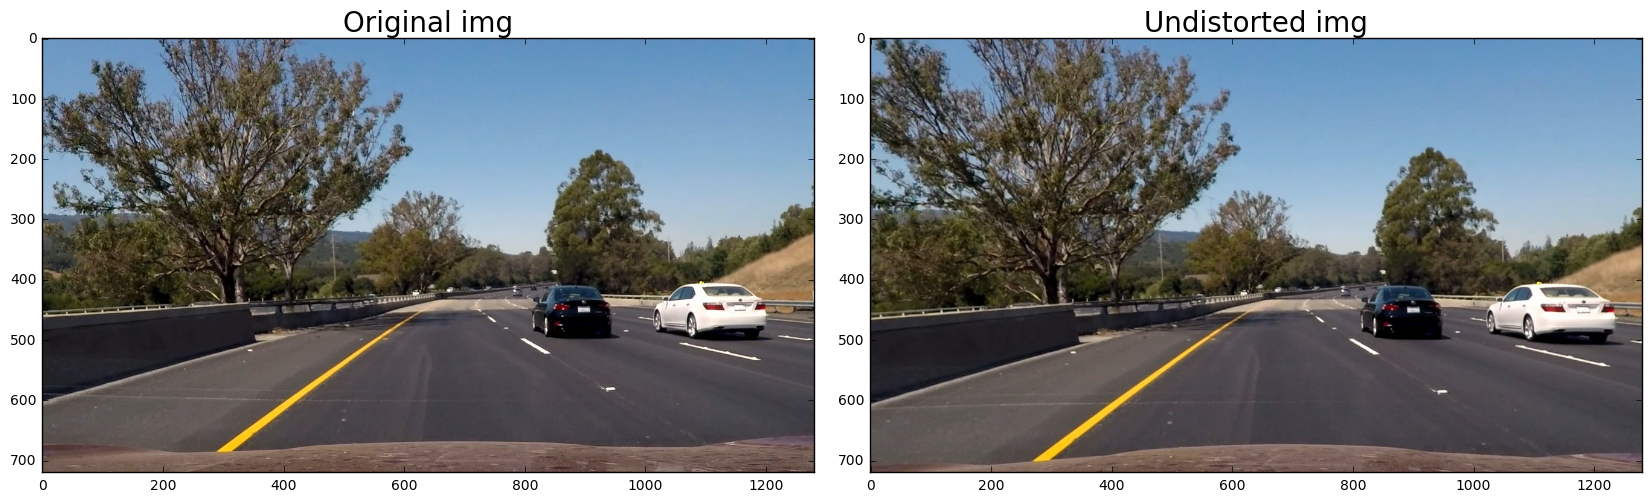

In [3]:
import os

folder = os.path.join(os.getcwd(), 'test_images')
output_folder = os.path.join(os.getcwd(), 'output_images')
image_list = os.listdir(folder)
n = 0

for fname in image_list:

    file = os.path.join(folder, fname)
    # check if the file is jpg file
    if str(file).endswith('.jpg'):
        # Read the image, note here the image is BGR file
        img = cv2.imread(os.path.join(folder, fname))
        # undistort the image with the distortion coefficient obtained above
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        output_name = 'undist-' + fname
        # Save the undistorted file to the output folder
        cv2.imwrite(os.path.join(output_folder, output_name), undist)
        # Randomly pickup a test image and show its original and undistorted, here I picked the  
        n += 1
        if n == 8:
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
            # Show  and compare the original and undistorted figures with plt.subplots()
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            f.tight_layout()
            ax1.imshow(img)
            ax1.set_title('Original img', fontsize=20)
            ax2.imshow(undist)
            ax2.set_title('Undistorted img', fontsize=20)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Use color transforms and gradients to create a thresholded binary image

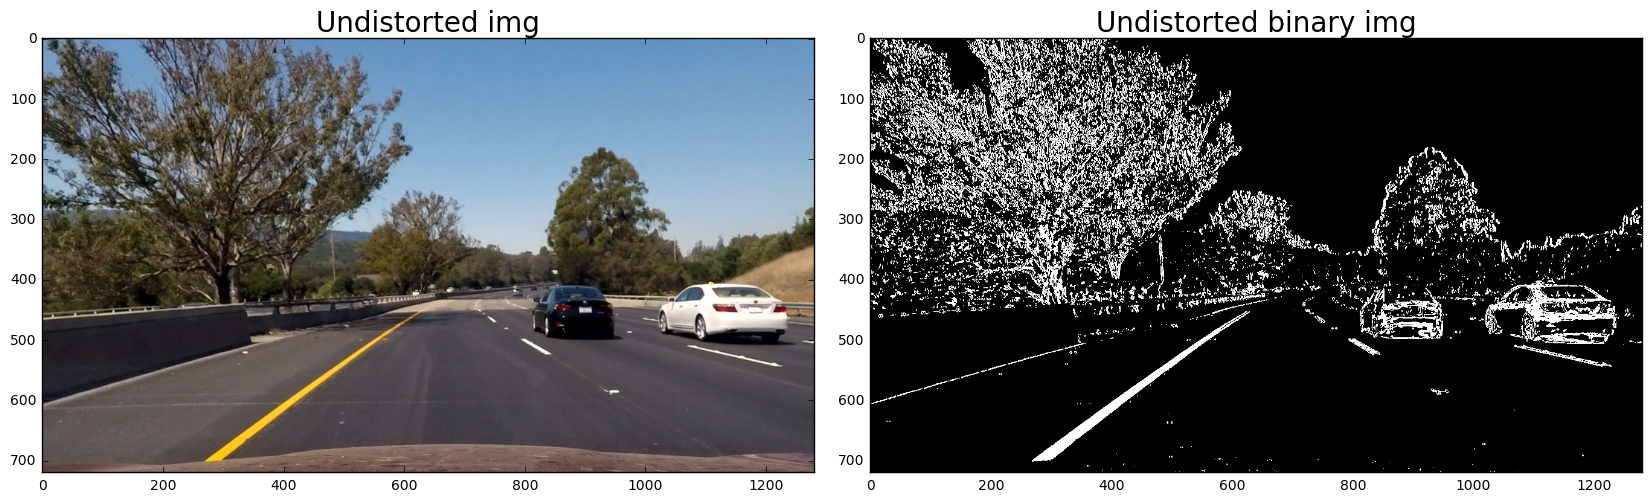

In [4]:
# Define function to generate thresholded binary image.
    
def binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*(abs_sobelx)/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary



folder = os.path.join(os.getcwd(), 'test_images')
output_folder = os.path.join(os.getcwd(), 'output_images')
image_list = os.listdir(folder)
n = 0

for fname in image_list:

    file = os.path.join(folder, fname)
    # check if the file is jpg file
    if str(file).endswith('.jpg'):
        # Read the image, note here the image is BGR file
        img = cv2.imread(os.path.join(folder, fname))
        # undistort the image with the distortion coefficient obtained above
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        undist_binary = binary(undist)
        undist_binary_file = np.dstack((undist_binary, undist_binary, undist_binary))*255
        output_name = 'undist-binary-' + fname
        # Save the undistorted file to the output folder
        cv2.imwrite(os.path.join(output_folder, output_name), undist_binary_file)
        # Randomly pickup a test image and show its original and undistorted, here I picked the  
        n += 1
        if n == 8:
            undist = cv2.cvtColor(undist,cv2.COLOR_BGR2RGB)
            # Show  and compare the undistorted figures and undistorted binary figures with plt.subplots()
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            f.tight_layout()
            ax1.imshow(undist)
            ax1.set_title('Undistorted img', fontsize=20)
            ax2.imshow(undist_binary, cmap = 'gray')
            ax2.set_title('Undistorted binary img', fontsize=20)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Apply a perspective transform to rectify binary image

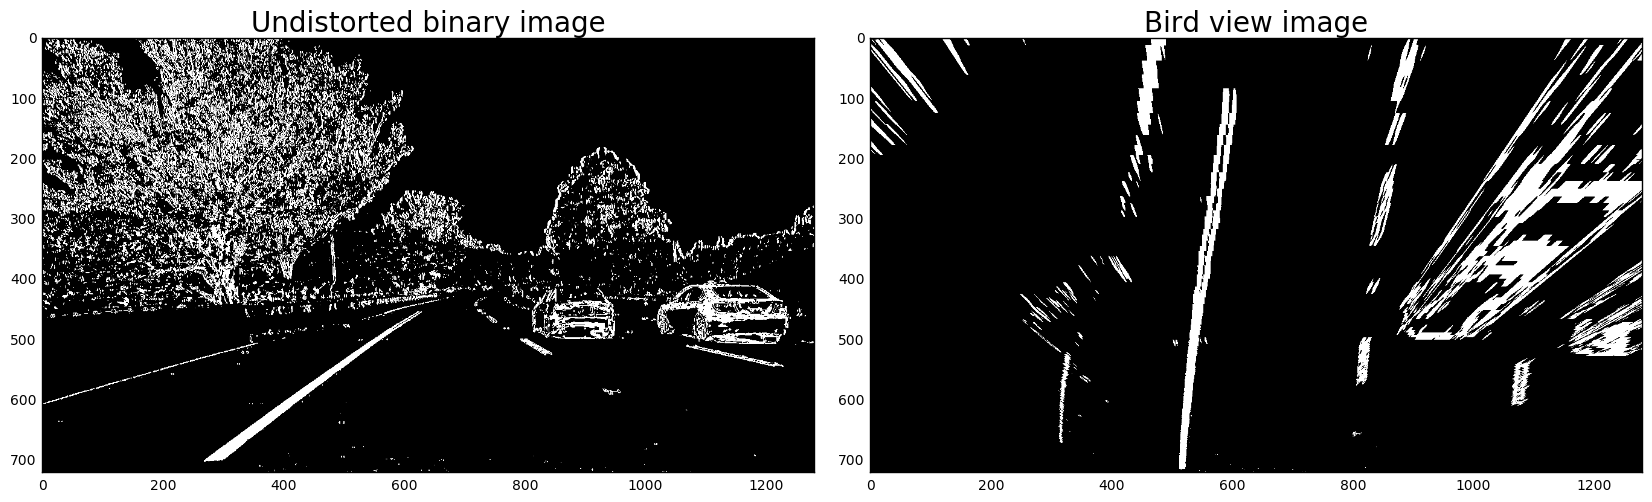

In [5]:
# Define the warped function 
def warped(img):            
    #define 4 source points src
    src = np.float32([[205, 720], [1107, 720], [596, 450], [685, 450]])
    # define 4 destination points dst
    dst = np.float32([[500, 720], [780, 720], [500, 0], [780, 0]])
    
    img_size = (img.shape[1], img.shape[0])
    #use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    #use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv


folder = os.path.join(os.getcwd(), 'test_images')
output_folder = os.path.join(os.getcwd(), 'output_images')
image_list = os.listdir(folder)
n = 0

for fname in image_list:

    file = os.path.join(folder, fname)
    # check if the file is jpg file
    if str(file).endswith('.jpg'):
        # Read the image, note here the image is BGR file
        img = cv2.imread(os.path.join(folder, fname))
        # undistort the image with the distortion coefficient obtained above
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        undist_binary = binary(undist)
        undist_binary_warped, M, Minv = warped(undist_binary)

        output_name = 'undist-binary-warped-' + fname
        undist_binary_warped_file = np.dstack((undist_binary_warped, undist_binary_warped, undist_binary_warped))*255
        # Save the undistorted file to the output folder
        cv2.imwrite(os.path.join(output_folder, output_name), undist_binary_warped_file)
        # Randomly pickup a test image and show its original and undistorted, here I picked the  
        n += 1
        if n == 8:
            # Show  and compare the undistorted binary figures and bird view figures with plt.subplots()
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            f.tight_layout()
            ax1.imshow(undist_binary, cmap = 'gray')
            ax1.set_title('Undistorted binary image', fontsize=20)
            ax2.imshow(undist_binary_warped, cmap = 'gray')
            ax2.set_title('Bird view image', fontsize=20)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Find_lanes function

In [6]:
def find_lanes(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    # Define a section on x-axis for searching the leftx_base and rightx_base, in my case it's 450 to 850
    leftx_base = np.argmax(histogram[450:midpoint]) + 450
    rightx_base = np.argmax(histogram[midpoint:850]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    l_current = leftx_base
    r_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 30
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return left_lane_inds, right_lane_inds


## Apply Find_lanes function and calculate the curvread

C:\Users\lei\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


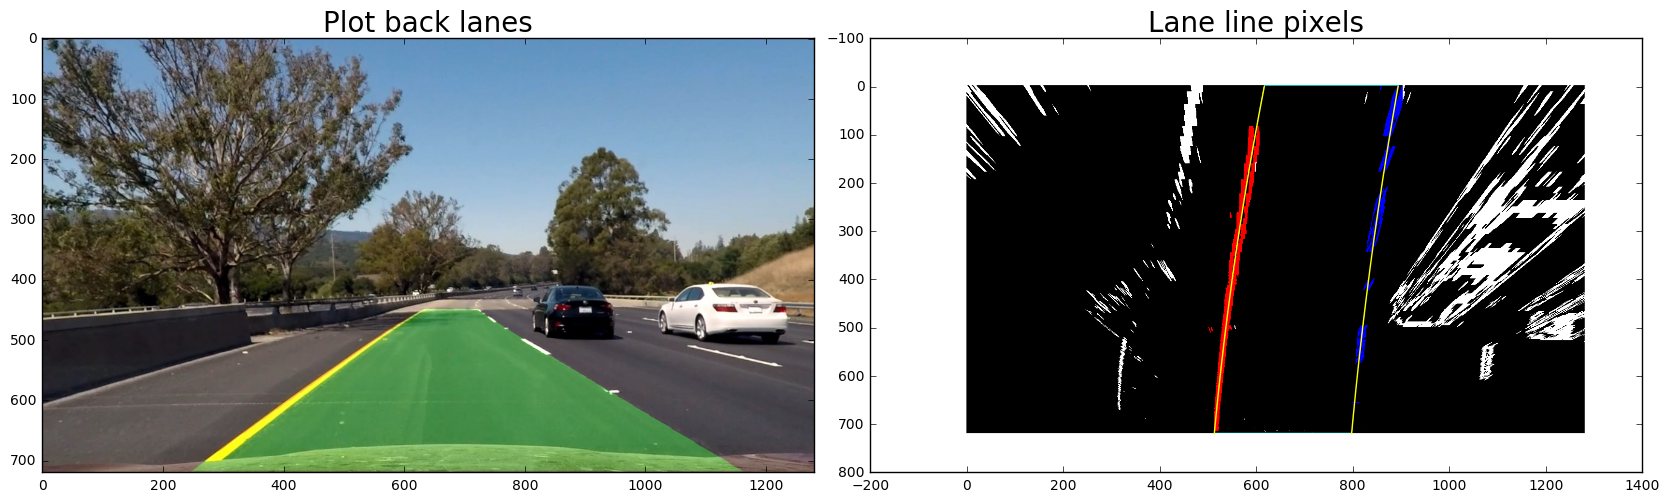

In [8]:
folder = os.path.join(os.getcwd(), 'test_images')
output_folder = os.path.join(os.getcwd(), 'output_images')
image_list = os.listdir(folder)
n = 0

for fname in image_list:

    file = os.path.join(folder, fname)
    # check if the file is jpg file
    if str(file).endswith('.jpg'):
        img = cv2.imread(os.path.join(folder, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # undistort the image with the distortion coefficient obtained above
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        cb = binary(undist)
        binary_warped, perspective_M, Minv = warped(cb)
        # Extract left and right line pixel positions
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_lane_inds, right_lane_inds = find_lanes(binary_warped)
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
        cv2.polylines(out_img, np.int_([pts]), 1, (0, 255, 255), 1)


        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        result_BGR = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        

        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result_BGR,'left_curverad '+str(left_curverad)+'    right_curverad '+str(right_curverad), (10,50), font, 1,(255,255,255),2)
        
        offset_from_center = ((right_fitx[np.argmax(ploty)] + left_fitx[np.argmax(ploty)])/2 - 640) * xm_per_pix
        if offset_from_center >= 0:
            offset = ' left'
        else:
            offset = ' right'
            
        cv2.putText(result_BGR,'The car is '+str(abs(offset_from_center))+'m'+offset+' from the center', (10,80), font, 1,(255,255,255),2)
        
        output_name1 = 'lane-line-pixels-' + fname
        cv2.imwrite(os.path.join(output_folder, output_name1), out_img)
        output_name2 = 'plot-back-lanes-' + fname
        cv2.imwrite(os.path.join(output_folder, output_name2), result_BGR)
        # Randomly pickup a test image and show its original and undistorted, here I picked the  
        n += 1
        if n == 8:
            # Show  and compare the undistorted binary figures and undistorted binary warped figures with plt.subplots()        
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
            f.tight_layout()
            ax1.imshow(result)
            ax1.set_title('Plot back lanes', fontsize=20)
            ax2.imshow(out_img)
            ax2.set_title('Lane line pixels', fontsize = 20)
            ax2.plot(left_fitx, ploty, color='yellow')
            ax2.plot(right_fitx, ploty, color='yellow')
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [9]:
class Line():
    def __init__(self):    
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit

l_line = Line()
r_line = Line()

def pipeline(img):
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    cb = binary(undist)
    binary_warped, perspective_M, Minv = warped(cb)
    # Extract left and right line pixel positions
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds, right_lane_inds = find_lanes(binary_warped)
                
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    if l_line.best_fit == None:
        l_line.best_fit = left_fit
    else:
        l_line.best_fit = cv2.addWeighted(l_line.best_fit, 0.85, left_fit, 0.15, 0)
    if r_line.best_fit == None:
        r_line.best_fit = right_fit
    else:
        r_line.best_fit = cv2.addWeighted(r_line.best_fit, 0.85, right_fit, 0.15, 0)
    left_fit = l_line.best_fit
    right_fit = r_line.best_fit
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'left_curverad '+str(left_curverad)+'    right_curverad '+str(right_curverad), (10,50), font, 1,(255,255,255),2)
    offset_from_center = ((right_fitx[np.argmax(ploty)] + left_fitx[np.argmax(ploty)])/2 - 640) * xm_per_pix
    if offset_from_center >= 0:
        offset = ' left'
    else:
        offset = ' right'
    cv2.putText(result,'The car is '+str(abs(offset_from_center))+'m'+offset+' from the center', (10,80), font, 1,(255,255,255),2)    
        
    return result
    

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [07:17<00:00,  2.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 7min 22s


In [12]:
HTML("""
<video width="960" height="480" controls>
  <source src="{0}">
</video>
""".format(output))